In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
a_string = 'a_1.002310'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 
                'stellar_mass', 'sfr', 'a_first_infall')
halocat_propnames = ('x', 'y', 'z', 'rvir')
histories = collate_catalog(a_string, history_colnames=history_colnames, 
                            halocat_propnames=halocat_propnames, verbose=True)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
... Assembling halo catalog data
... Cross-matching on halo_id

Number of objects in history catalog = 676028
Number of objects in halo catalog = 12085858
Number of matching objects = 640466
Fraction of objects appearing in both catalogs = 0.947
New colnames to add from halo catalog = ['y', 'x', 'z', 'rvir']

Number of galaxies = 676028


In [4]:
histories['ssfr'] = np.log10(histories['sfr']/histories['stellar_mass'])

In [5]:
from halotools.mock_observables import return_xyz_formatted_array, radial_profile_3d

In [6]:
cluster_mask = (histories['halo_mpeak'] > 1e14) & (histories['gal_type'] == 'central')

cluster_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=cluster_mask, period=250)
clusters = histories[cluster_mask]

In [17]:
sm_low, sm_high = 10, 10.25
sm_mask = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask, period=250.0)
sample = histories[sm_mask]

In [31]:
sm_low, sm_high = 10.5, 10.75
sm_mask2 = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample2_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask2, period=250.0)
sample2 = histories[sm_mask2]

In [37]:
sm_low, sm_high = 9, 9.25
sm_mask3 = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample3_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask3, period=250.0)
sample3 = histories[sm_mask3]

In [45]:
rbins_normalized = np.linspace(0.25, 25, 20)
rbins_normalized_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

cluster_result = radial_profile_3d(cluster_pos, sample_pos, sample['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)

cluster_result2 = radial_profile_3d(cluster_pos, sample2_pos, sample2['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)

cluster_result3 = radial_profile_3d(cluster_pos, sample3_pos, sample3['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)


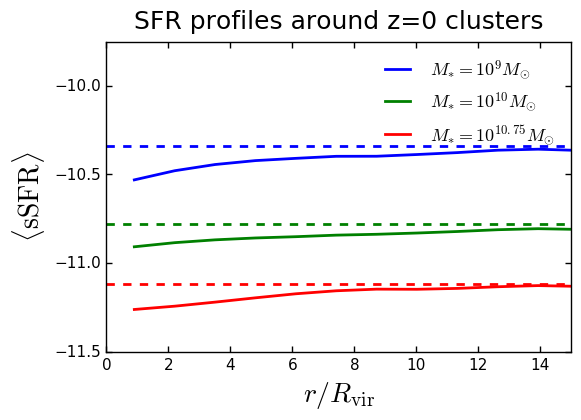

In [54]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

y3 = medfilt(cluster_result3, 3)
y3 = savgol_filter(y3, 9, 3)
ax.plot(rbins_normalized_midpoints, y3, 
        color='blue', linewidth=2, label=r'$M_{\ast} = 10^{9}M_{\odot}$')
mean_sample3_ssfr = np.mean(sample3['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample3_ssfr, ls='--', color='blue', linewidth=2)

y = medfilt(cluster_result, 3)
y = savgol_filter(y, 9, 3)
ax.plot(rbins_normalized_midpoints, y, 
        color='green', linewidth=2, label=r'$M_{\ast} = 10^{10}M_{\odot}$')
mean_sample_ssfr = np.mean(sample['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample_ssfr, ls='--', color='green', linewidth=2)

y2 = medfilt(cluster_result2, 3)
y2 = savgol_filter(y2, 9, 3)
ax.plot(rbins_normalized_midpoints, y2, 
        color='red', linewidth=2, label=r'$M_{\ast} = 10^{10.75}M_{\odot}$')
mean_sample2_ssfr = np.mean(sample2['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample2_ssfr, ls='--', color='red', linewidth=2)


xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title(r'SFR profiles around z=0 clusters', 
                     fontsize=18, y=1.02) 

plt.xlabel(r'$r / R_{\rm vir}$', size=20)
plt.ylabel(r'$\langle{\rm sSFR}\rangle$', size=20)
plt.xticks(fontsize=17); plt.yticks(fontsize=17)
plt.xlim(xmin = 0., xmax=15)
plt.ylim(ymin = -11.5, ymax = -9.75)

plt.legend(loc='upper right', fontsize=13)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')
plt.xticks(fontsize=11); plt.yticks(fontsize=11)

fig.savefig('FIGS/cluster_profiles_sm_dependence.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [9]:
clusters['rvir'].min()

702.36902